In [1]:
import assign06 as a06

import pandas as pd 
import matplotlib.pyplot as plt 
 
import numpy as np 
import skimage as sk 
import skimage.io as skio 
import skimage.transform as sktr 
import skimage.filters as skfl 
import skimage.feature as skft 
import skimage.color as skcol 
import skimage.exposure as skexp 
import skimage.morphology as skmr

import skimage.util as skut 
import skimage.measure as skme 
  
import sklearn.model_selection as le_ms 
import sklearn.decomposition as le_de 
import sklearn.discriminant_analysis as le_di 
import sklearn.preprocessing as le_pr 
import sklearn.linear_model as le_lm 
import sklearn.metrics as le_me

%matplotlib inline

### Classification with vessel features

In [2]:
DATA_DIR = "./data/"

groundTruthFr = pd.read_csv(DATA_DIR + "messidorGroundTruth.csv", index_col="ID")
vessFeatFr = pd.read_csv(DATA_DIR + "vesselFeatures.csv", index_col="ID")
lesionFeatFr = pd.read_csv(DATA_DIR + "lesionFeatures.csv", index_col="ID")

lbl = (groundTruthFr["retinopathy"] == 0) | (groundTruthFr["retinopathy"] > 2)

Xvess = vessFeatFr[lbl].values
Xles = lesionFeatFr[lbl].values
y = (groundTruthFr[lbl]["retinopathy"].values > 0).astype(int)

In [3]:
N_SPLITS = 10
kfold = le_ms.KFold(n_splits=N_SPLITS)

X = Xvess.copy()

yPredictionArr = np.zeros(len(y))
yPredictionArr[:] = -1

clfLog = le_lm.LogisticRegression(penalty="l1", solver="liblinear", warm_start=True, class_weight={0: 0.5, 1: 0.5}, C=0.1)

for train_index, test_index in kfold.split(range(len(y))):
    trainX = X[train_index]
    trainY = y[train_index]
    testX = X[test_index]
    testY = y[test_index]

    scaler = le_pr.RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
    scaler.fit(trainX)
    trainX = scaler.transform(trainX)
    testX = scaler.transform(testX)

    clfLog.fit(trainX, trainY)
    yPredictionArr = clfLog.predict_proba(X)[:, 1]
    yTestPredArr = clfLog.predict_proba(testX)[:, 1]
    

In the above cell, the instructions ask us to store the probability in the yPredictionArr array. However the size of this array is the size of the entire dataset. Therefore, instead of using the test set, I am using the entire dataset for prediction. 

Additionally, if yPredictionArr array was a 2D array with the size of the second dimension being the number of folds, it could have stored the predictions for all the folds. 

In the instructions, a new model is instantiated every iteration. Instead, I chose to instantiate a model before the looping with the parameter warm_start=True. 

### Classifier Evaluation

/Users/cmokashi/miniconda3/envs/bmi6331/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


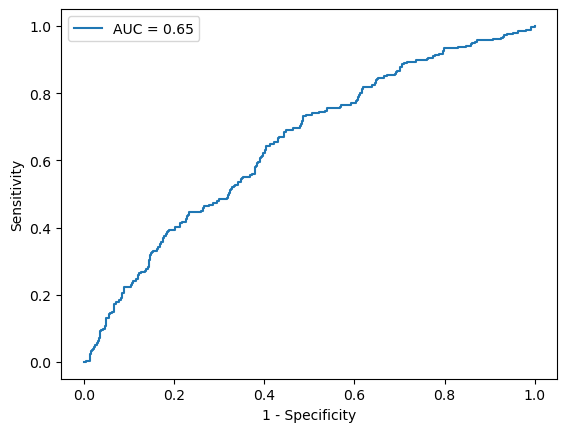

In [4]:
fpr, tpr, thresholds = le_me.roc_curve(y_true=y, y_score=yPredictionArr)
# fpr, tpr, thresholds = le_me.roc_curve(y_true=testY, y_score=yTestPredArr)

code = a06.Assign()
fig = code.plot_roc(fpr, tpr, le_me.auc(fpr, tpr))
fig.show()

In [5]:
list_diff = sorted([[tp, fp, threshold, tp - fp] for fp, tp, threshold in zip(fpr, tpr, thresholds)], reverse=True, key=lambda item: item[-1])
threshold = list_diff[0][2]
print("Threshold: ", threshold)

yPredictionArr = np.array(list(map(lambda item: 1 if item > threshold else 0, yPredictionArr)))

tn, fp, fn, tp = le_me.confusion_matrix(y, yPredictionArr).ravel()
accuracy, sensitivity, specificity = (tn + tp)/(tn + fp + fn + fp), tp/(tp + fn), tn/(tn + fp)
for name, metric in zip(["Accuracy", "Sensitivity", "Specificity", "Confusion Matrix"], [accuracy, sensitivity, specificity, le_me.confusion_matrix(y, yPredictionArr)]):
    print(name, " ---> ", metric)

Threshold:  0.16216963398054332
Accuracy  --->  0.528344671201814
Sensitivity  --->  0.7283464566929134
Specificity  --->  0.5137111517367459
Confusion Matrix  --->  [[281 266]
 [ 69 185]]


### Nested Cross-Validation

In [6]:
mod2 =  le_lm.LogisticRegression(penalty="l1", solver="liblinear", warm_start=True, class_weight={0: 0.5, 1: 0.5})
parameterGrid = {"C": np.linspace(0.001, 1, 1000)}
randSearch = le_ms.RandomizedSearchCV(mod2, parameterGrid, cv=10, n_iter=10, scoring="roc_auc", refit=True)

randSearch.fit(trainX, trainY)

RandomizedSearchCV(cv=10,
                   estimator=LogisticRegression(class_weight={0: 0.5, 1: 0.5},
                                                penalty='l1',
                                                solver='liblinear',
                                                warm_start=True),
                   param_distributions={'C': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032...
       0.937, 0.938, 0.939, 0.94 , 0.941, 0.942, 0.943, 0.944, 0.945,
       0.946, 0.947, 0.948, 0.949, 0.95 , 0.951, 0.952, 0.953, 0.954,
       0.955, 0.956, 0.957, 0.958, 0.959, 0.96 , 0.961, 0.962, 0.963,
       0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97 , 0.971, 0.972,
       0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979, 0.98 , 0.981,
       0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0

/Users/cmokashi/miniconda3/envs/bmi6331/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == "__main__":


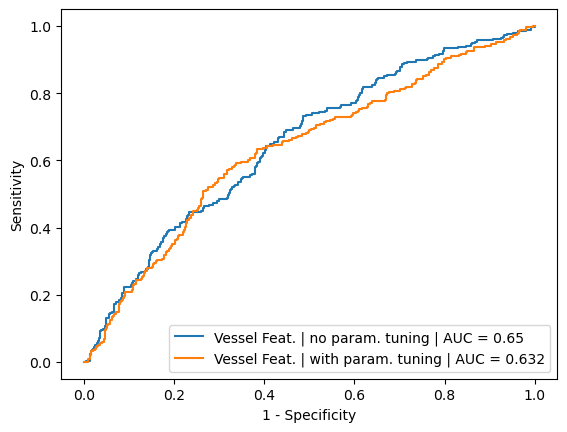

In [7]:
yPredNCV = randSearch.best_estimator_.predict_proba(X)[:, 1]

fprNCV, tprNCV, thresholdsNCV = le_me.roc_curve(y_true=y, y_score=yPredNCV)

# fig = code.plot_roc(fpr, tpr, le_me.auc(fpr, tpr))
# fig.show()

fig = code.plot_roc_multiple([(fpr, tpr, le_me.auc(fpr, tpr), "Vessel Feat. | no param. tuning | "), (fprNCV, tprNCV, le_me.auc(fprNCV, tprNCV), "Vessel Feat. | with param. tuning | ")])
fig.show()

### Adding Lesion features

/Users/cmokashi/miniconda3/envs/bmi6331/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


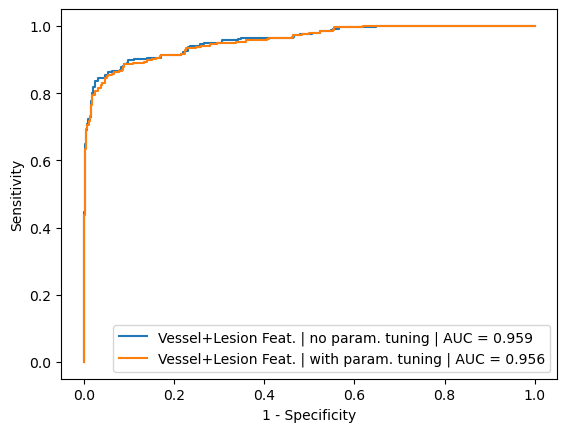

In [14]:
Xnew = np.ma.concatenate((Xvess, Xles), axis=1)

N_SPLITS = 10
kfold = le_ms.KFold(n_splits=N_SPLITS)

X = Xnew

yPredictionArr = np.zeros(len(y))
yPredictionArr[:] = -1

clfLog = le_lm.LogisticRegression(penalty="l1", solver="liblinear", warm_start=True, class_weight={0: 0.5, 1: 0.5}, C=0.1)

for train_index, test_index in kfold.split(range(len(y))):
    trainX = X[train_index]
    trainY = y[train_index]
    testX = X[test_index]
    testY = y[test_index]

    scaler = le_pr.RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
    scaler.fit(trainX)
    trainX = scaler.transform(trainX)
    testX = scaler.transform(testX)

    clfLog.fit(trainX, trainY)
    yPredictionArr = clfLog.predict_proba(X)[:, 1]
    yTestPredArr = clfLog.predict_proba(testX)[:, 1]

fpr, tpr, thresholds = le_me.roc_curve(y_true=y, y_score=yPredictionArr)
mod2 =  le_lm.LogisticRegression(penalty="l1", solver="liblinear", warm_start=True, class_weight={0: 0.5, 1: 0.5})
parameterGrid = {"C": np.linspace(0.001, 1, 1000)}
randSearch = le_ms.RandomizedSearchCV(mod2, parameterGrid, cv=10, n_iter=10, scoring="roc_auc", refit=True)

randSearch.fit(trainX, trainY)

yPredNCV = randSearch.best_estimator_.predict_proba(X)[:, 1]

fprNCV, tprNCV, thresholdsNCV = le_me.roc_curve(y_true=y, y_score=yPredNCV)

fig = code.plot_roc_multiple([(fpr, tpr, le_me.auc(fpr, tpr), "Vessel+Lesion Feat. | no param. tuning | "), (fprNCV, tprNCV, le_me.auc(fprNCV, tprNCV), "Vessel+Lesion Feat. | with param. tuning | ")])
fig.show()